<a href="https://colab.research.google.com/github/ifarady/attention-in-seismic/blob/main/CA_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.cm as cm


In [ ]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'unet_model.pth'


cuda


In [ ]:
#Specify Paths and Configuration

image_path = "competition_data/train/images"
mask_path = "competition_data/train/masks"
val_image_path = "competition_data/val/images"
val_mask_path = "competition_data/val/masks"

In [ ]:
#Load and Preprocess Data for Visualization
names = ['4c4556fff0','4c8132dc73','4c36178b41']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

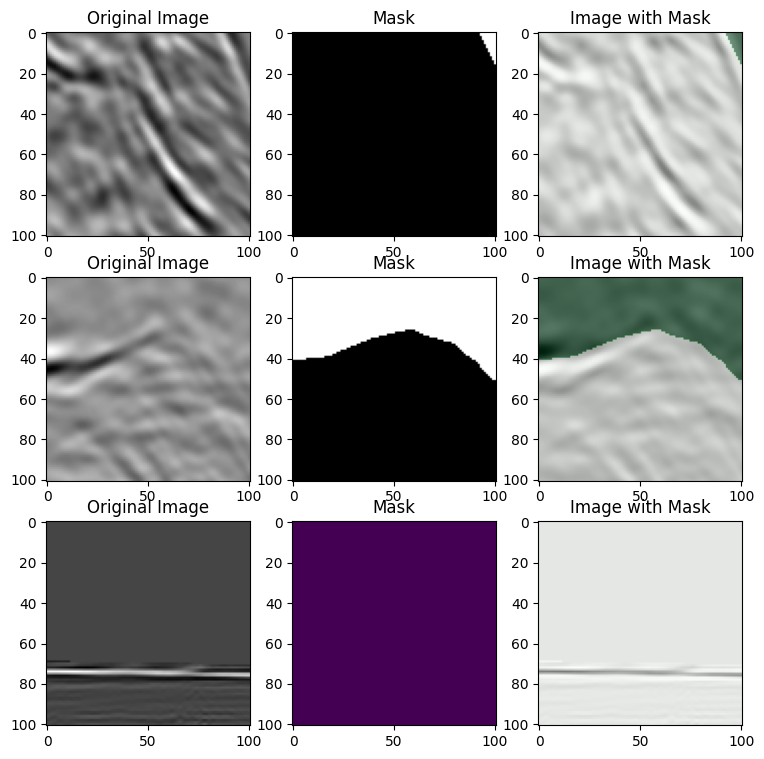

In [ ]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze(), cmap="Greys")
    ax.imshow(y[i].squeeze(), alpha=0.5, cmap="Greens")
    ax.set_title("Image with Mask")

plt.show()

In [ ]:
# Step 7: Define Custom Dataset Class
class segmentDataset(Dataset):
    def __init__(self, image_path, mask_path):
        self.image_path = image_path
        self.mask_path = mask_path

        image_list = glob.glob(image_path + '/*.png')
        sample_names = [file.split('/')[-1].split('.')[0] for file in image_list]
        self.sample_names = sample_names
        self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_path, self.sample_names[idx] + '.png'))
        mask = Image.open(os.path.join(self.mask_path, self.sample_names[idx] + '.png'))
        return self.transforms(image), self.transforms(mask)

    def __len__(self):
        return len(self.sample_names)

In [ ]:
# Step 8: Initialize Dataset
train_dataset = segmentDataset(image_path, mask_path)
# Step 5: Validation Dataset
val_dataset = segmentDataset(val_image_path, val_mask_path)


In [ ]:
# # Step 6: Validation DataLoader
BATCH_SIZE = 64
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

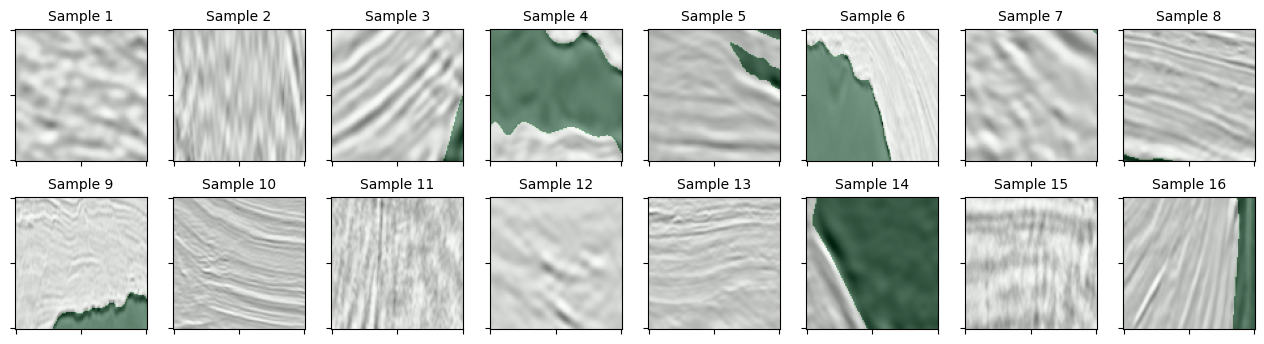

In [ ]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [ ]:
# Step 10: Define Model Architecture

"""
This class defines a convolutional block, which consists of a convolutional layer followed by batch normalization.
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.activation = activation
        # Convolutional layer with specified parameters
        self.conv = nn.Conv2d(in_channels, filters, size, stride=stride, padding=size // 2)
        # Batch normalization layer
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        # Forward pass through the convolutional block
        x = self.conv(x)  # Apply convolution
        x = self.norm(x)  # Apply batch normalization
        if self.activation:
            return F.relu(x)  # Apply ReLU activation if specified
        else:
            return x


"""
This class defines a residual block, which consists of two convolutional blocks and optional residual connections.
"""
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, size=3):
        super(ResidualBlock, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        # First convolutional block
        self.conv1 = ConvBlock(in_channels, filters, size)
        # Second convolutional block with no activation
        self.conv2 = ConvBlock(filters, filters, size, activation=False)

    def forward(self, x):
        residual = x  # Save input as residual
        x = F.relu(x)  # Apply ReLU activation
        x = self.norm(x)  # Apply batch normalization
        x = self.conv1(x)  # First convolutional block
        x = self.conv2(x)  # Second convolutional block
        # Optionally add residual connection
        # x += residual  # Uncomment if you want to use residual connections
        return x


"""
This class defines a deconvolutional block, which consists of a transposed convolutional layer.
"""
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(DeconvBlock, self).__init__()
        # Transposed convolutional layer
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x1, x2):
        xd = self.deconv(x1)  # Apply transposed convolution
        # Concatenate feature maps from the transposed convolution with feature maps from a previous stage
        x = torch.cat([xd, x2], dim=1)
        return x

"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])

        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x

In [ ]:
# Step 11: Define U-Net Model
class UnetModel(nn.Module):

    def __init__(self, filters=16, dropout=0.5):
        super(UnetModel, self).__init__()
        # Define encoder layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU()
        )

        # create channel attention
        self.attention_1 = ChannelAttention(filters)

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        # create channel attention
        self.attention_2 = ChannelAttention(filters * 2)

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )

        # create channel attention
        self.attention_3 = ChannelAttention(filters * 4)

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )

        # create channel attention
        self.attention_4 = ChannelAttention(filters * 8)

        # Define middle layers
        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding=3//2),
            ResidualBlock(filters * 16, filters * 16),
            ResidualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )

        self.attention_5 = ChannelAttention(filters * 16)

        # Define decoder layers
        self.deconv4 = DeconvBlock(filters * 16, filters * 8, 2)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )

        self.attention_6 = ChannelAttention(filters * 8)

        self.deconv3 = DeconvBlock(filters * 8, filters * 4, 3)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )

        self.attention_7 = ChannelAttention(filters * 4)

        self.deconv2 = DeconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.attention_8 = ChannelAttention(filters * 2)

        self.deconv1 = DeconvBlock(filters * 2, filters, 3)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, 1, 3, padding=1)
        )

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.attention_1(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.attention_2(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.attention_3(conv3)
        conv4 = self.conv4(conv3)
        conv4 = self.attention_4(conv4)
        x = self.middle(conv4)
        x = self.attention_5(x)
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
#         x = self.attention_6(x)
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
#         x = self.attention_7(x)
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
#         x = self.attention_8(x)
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)
        return x

In [ ]:
# Step 13: Training Function
def train_one_batch(model, x, y, optimizer, loss_fn):
    x, y = x.to(device), y.to(device)

    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = get_iou_score(outputs, y).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item()

In [ ]:
# Step 14: Validation Function
def validate_one_batch(model, x, y, loss_fn):
    x, y = x.to(device), y.to(device)

    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = get_iou_score(outputs, y).mean()

    return loss.item(), iou.item()


In [ ]:
# Step 14: Set Training Hyperparameters
NUM_EPOCHS = 200
BATCH_SIZE = 64

In [ ]:
# Step 15: Initialize Model, Optimizer, and Loss Function
model = UnetModel().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Step 15: Get IoU Score
def get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs < 0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1, 2))
    union = (A | B).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou

In [ ]:
# Step 16: Create DataLoader for Training Dataset
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")


56 steps per epoch


In [ ]:
# Step 16: Model Training

model = UnetModel().to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
loss_fn = nn.BCEWithLogitsLoss()

train_dataset = segmentDataset(image_path, mask_path)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_losses = []
train_ious = []
val_losses = []
val_ious = []

max_val_iou = -1
best_epoch_loss = -1
best_epoch = -1

start = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))

    running_train_loss = []
    running_train_iou = []
    running_val_loss = []
    running_val_iou = []

    # Training Phase
    model.train()
    for step, (x_train, y_train) in enumerate(train_dataloader):
        train_loss, train_iou = train_one_batch(model, x_train, y_train, optimizer, loss_fn)
        running_train_loss.append(train_loss)
        running_train_iou.append(train_iou)
        print('\rTraining | Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(
            epoch, NUM_EPOCHS, step+1, len(train_dataloader), train_loss, train_iou), end="")

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for x_val, y_val in val_dataloader:
            val_loss, val_iou = validate_one_batch(model, x_val, y_val, loss_fn)
            running_val_loss.append(val_loss)
            running_val_iou.append(val_iou)

    # Compute average metrics for the epoch
    avg_train_loss = sum(running_train_loss) / len(running_train_loss)
    avg_train_iou = sum(running_train_iou) / len(running_train_iou)
    avg_val_loss = sum(running_val_loss) / len(running_val_loss)
    avg_val_iou = sum(running_val_iou) / len(running_val_iou)

    # Append to lists for plotting
    train_losses.append(avg_train_loss)
    train_ious.append(avg_train_iou)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)

    # Print epoch summary
    print('\rTraining | Epoch [{}/{}], Avg Loss: {:.4f}, Avg IoU: {:.4f}'.format(
        epoch, NUM_EPOCHS, avg_train_loss, avg_train_iou))
    print('\rValidation | Epoch [{}/{}], Avg Loss: {:.4f}, Avg IoU: {:.4f}'.format(
        epoch, NUM_EPOCHS, avg_val_loss, avg_val_iou))

    # Adjust learning rate based on validation IoU
    scheduler.step(avg_val_iou)

    if avg_val_iou > max_val_iou:
        best_epoch = epoch
        max_val_iou = avg_val_iou
        best_epoch_loss = avg_val_loss
        print('\rSave best model with mIoU = {}'.format(avg_val_iou))
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        print('\rBest mIoU: {} at epoch {}'.format(max_val_iou, best_epoch))

----------
Epoch 1/200
Training | Epoch [1/200], Avg Loss: 0.5073, Avg IoU: 0.37050.5159
Validation | Epoch [1/200], Avg Loss: 1.3623, Avg IoU: 0.3662
Save best model with mIoU = 0.36623344038214
----------
Epoch 2/200
Training | Epoch [2/200], Avg Loss: 0.3659, Avg IoU: 0.55500.5341
Validation | Epoch [2/200], Avg Loss: 0.5856, Avg IoU: 0.4638
Save best model with mIoU = 0.4637921452522278
----------
Epoch 3/200
Training | Epoch [3/200], Avg Loss: 0.3302, Avg IoU: 0.58340.5629
Validation | Epoch [3/200], Avg Loss: 0.3117, Avg IoU: 0.5979
Save best model with mIoU = 0.5978507655007499
----------
Epoch 4/200
Training | Epoch [4/200], Avg Loss: 0.3027, Avg IoU: 0.59370.5499
Validation | Epoch [4/200], Avg Loss: 0.3218, Avg IoU: 0.4361
Best mIoU: 0.5978507655007499 at epoch 3
----------
Epoch 5/200
Training | Epoch [5/200], Avg Loss: 0.2852, Avg IoU: 0.59230.5312
Validation | Epoch [5/200], Avg Loss: 0.2457, Avg IoU: 0.6110
Save best model with mIoU = 0.6109734347888401
----------
Epoch 6

Training | Epoch [43/200], Avg Loss: 0.1292, Avg IoU: 0.75820.6590
Validation | Epoch [43/200], Avg Loss: 0.1774, Avg IoU: 0.7200
Best mIoU: 0.747805484703609 at epoch 38
----------
Epoch 44/200
Training | Epoch [44/200], Avg Loss: 0.1390, Avg IoU: 0.74650.9353
Validation | Epoch [44/200], Avg Loss: 0.1564, Avg IoU: 0.7377
Best mIoU: 0.747805484703609 at epoch 38
----------
Epoch 45/200
Training | Epoch [45/200], Avg Loss: 0.1277, Avg IoU: 0.75250.7703
Validation | Epoch [45/200], Avg Loss: 0.1454, Avg IoU: 0.7415
Best mIoU: 0.747805484703609 at epoch 38
----------
Epoch 46/200
Training | Epoch [46/200], Avg Loss: 0.1214, Avg IoU: 0.75720.8349
Validation | Epoch [46/200], Avg Loss: 0.1501, Avg IoU: 0.7458
Best mIoU: 0.747805484703609 at epoch 38
----------
Epoch 47/200
Training | Epoch [47/200], Avg Loss: 0.1348, Avg IoU: 0.74780.5948
Validation | Epoch [47/200], Avg Loss: 0.1327, Avg IoU: 0.7485
Save best model with mIoU = 0.7485127023288182
----------
Epoch 48/200
Training | Epoch [4

Training | Epoch [85/200], Avg Loss: 0.0668, Avg IoU: 0.81730.7397
Validation | Epoch [85/200], Avg Loss: 0.1570, Avg IoU: 0.7783
Best mIoU: 0.7812641603606088 at epoch 83
----------
Epoch 86/200
Training | Epoch [86/200], Avg Loss: 0.0671, Avg IoU: 0.81620.8535
Validation | Epoch [86/200], Avg Loss: 0.1514, Avg IoU: 0.7809
Best mIoU: 0.7812641603606088 at epoch 83
----------
Epoch 87/200
Training | Epoch [87/200], Avg Loss: 0.0656, Avg IoU: 0.81730.8468
Validation | Epoch [87/200], Avg Loss: 0.1513, Avg IoU: 0.7743
Best mIoU: 0.7812641603606088 at epoch 83
----------
Epoch 88/200
Training | Epoch [88/200], Avg Loss: 0.0636, Avg IoU: 0.81990.7840
Validation | Epoch [88/200], Avg Loss: 0.1585, Avg IoU: 0.7792
Best mIoU: 0.7812641603606088 at epoch 83
----------
Epoch 89/200
Training | Epoch [89/200], Avg Loss: 0.0646, Avg IoU: 0.82030.7878
Validation | Epoch [89/200], Avg Loss: 0.1627, Avg IoU: 0.7953
Save best model with mIoU = 0.79534193447658
----------
Epoch 90/200
Training | Epoch 

Training | Epoch [127/200], Avg Loss: 0.0615, Avg IoU: 0.82040.8142
Validation | Epoch [127/200], Avg Loss: 0.1639, Avg IoU: 0.7825
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 128/200
Training | Epoch [128/200], Avg Loss: 0.0616, Avg IoU: 0.82100.8466
Validation | Epoch [128/200], Avg Loss: 0.1642, Avg IoU: 0.7822
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 129/200
Training | Epoch [129/200], Avg Loss: 0.0607, Avg IoU: 0.82570.8346
Validation | Epoch [129/200], Avg Loss: 0.1630, Avg IoU: 0.7813
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 130/200
Training | Epoch [130/200], Avg Loss: 0.0619, Avg IoU: 0.81960.6899
Validation | Epoch [130/200], Avg Loss: 0.1638, Avg IoU: 0.7821
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 131/200
Training | Epoch [131/200], Avg Loss: 0.0606, Avg IoU: 0.82100.9054
Validation | Epoch [131/200], Avg Loss: 0.1618, Avg IoU: 0.7803
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 132/200
Training | Epoc

Training | Epoch [169/200], Avg Loss: 0.0608, Avg IoU: 0.82420.7749
Validation | Epoch [169/200], Avg Loss: 0.1590, Avg IoU: 0.7826
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 170/200
Training | Epoch [170/200], Avg Loss: 0.0577, Avg IoU: 0.82630.8485
Validation | Epoch [170/200], Avg Loss: 0.1622, Avg IoU: 0.7814
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 171/200
Training | Epoch [171/200], Avg Loss: 0.0597, Avg IoU: 0.82370.7698
Validation | Epoch [171/200], Avg Loss: 0.1598, Avg IoU: 0.7819
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 172/200
Training | Epoch [172/200], Avg Loss: 0.0600, Avg IoU: 0.82110.8741
Validation | Epoch [172/200], Avg Loss: 0.1597, Avg IoU: 0.7783
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 173/200
Training | Epoch [173/200], Avg Loss: 0.0608, Avg IoU: 0.82280.8193
Validation | Epoch [173/200], Avg Loss: 0.1603, Avg IoU: 0.7819
Best mIoU: 0.79534193447658 at epoch 89
----------
Epoch 174/200
Training | Epoc

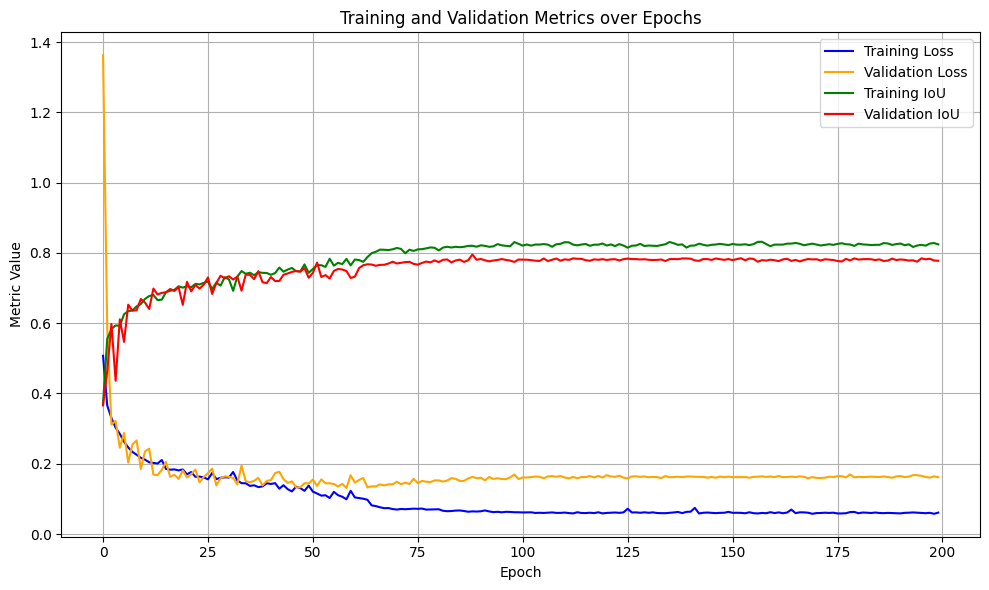

In [ ]:
# Step 18: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_losses, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_losses, label='Validation Loss', color='orange')

# Plotting Training IoU
plt.plot(train_ious, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_ious, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Step 19: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)

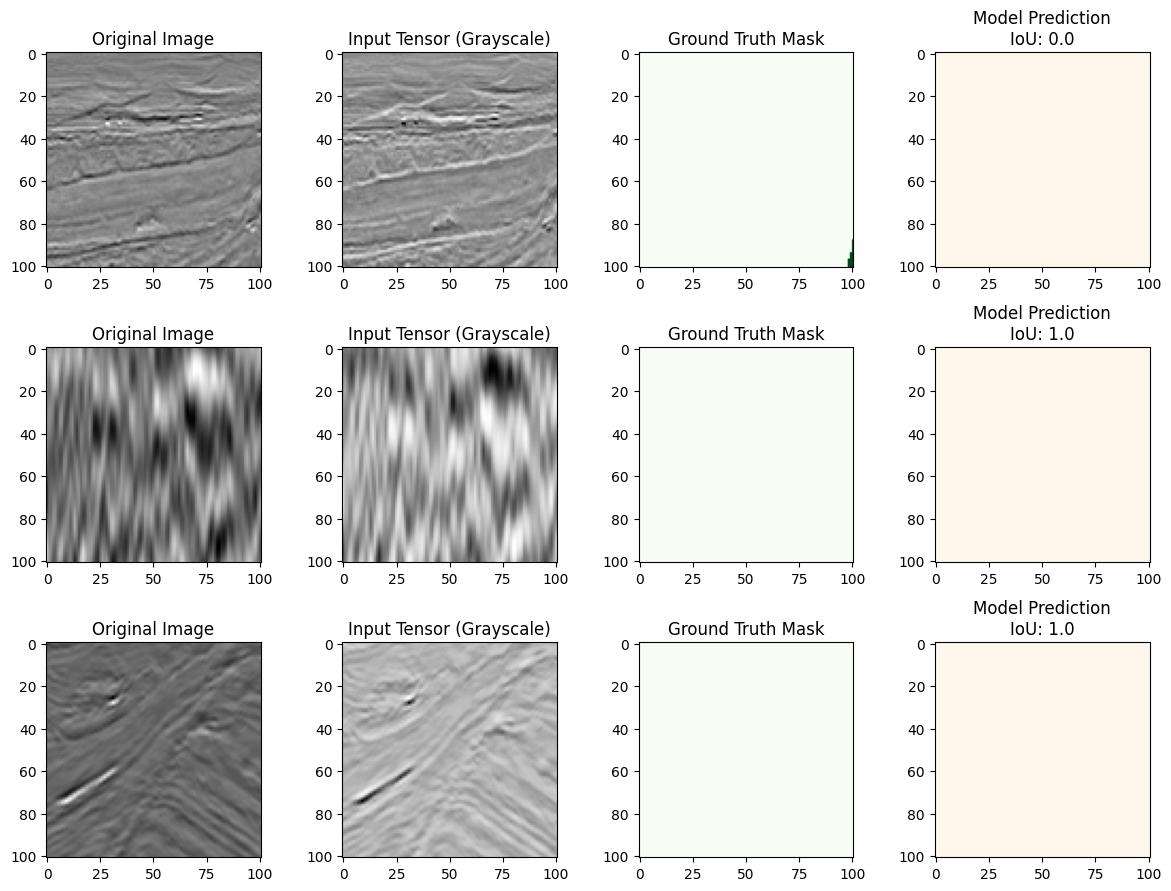

In [ ]:
# Step 20: Evaluate Model on Sample Images

# Set the model to evaluation mode
model.eval()

# Define the sample image names
names = ['00a3af90ab', '0a7e067255', '0a18b314fc']

# Load the sample images and masks
images = [Image.open(os.path.join(val_image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(val_mask_path, name+'.png')) for name in names]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# Generate predictions using the model
outputs = model(x)
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
ious = get_iou_score(outputs, y)

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))
for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(images[i])
    ax.set_title("Original Image")

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    ax.imshow(x[i].squeeze(), cmap="Greys")
    ax.set_title("Input Tensor (Grayscale)")

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze(), cmap="Greens")
    ax.set_title("Ground Truth Mask")

    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    ax.imshow(preds[i].squeeze(), cmap="OrRd")
    ax.set_title("Model Prediction\nIoU: " + str(round(ious[i].item(), 2)))

plt.tight_layout()
plt.show()

In [ ]:
# Step 21: Make Predictions on Batch of Images
trainiter = iter(train_dataloader)
images, masks = next(trainiter)

outputs = model(images)
preds = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
ious = get_iou_score(outputs, masks).numpy()

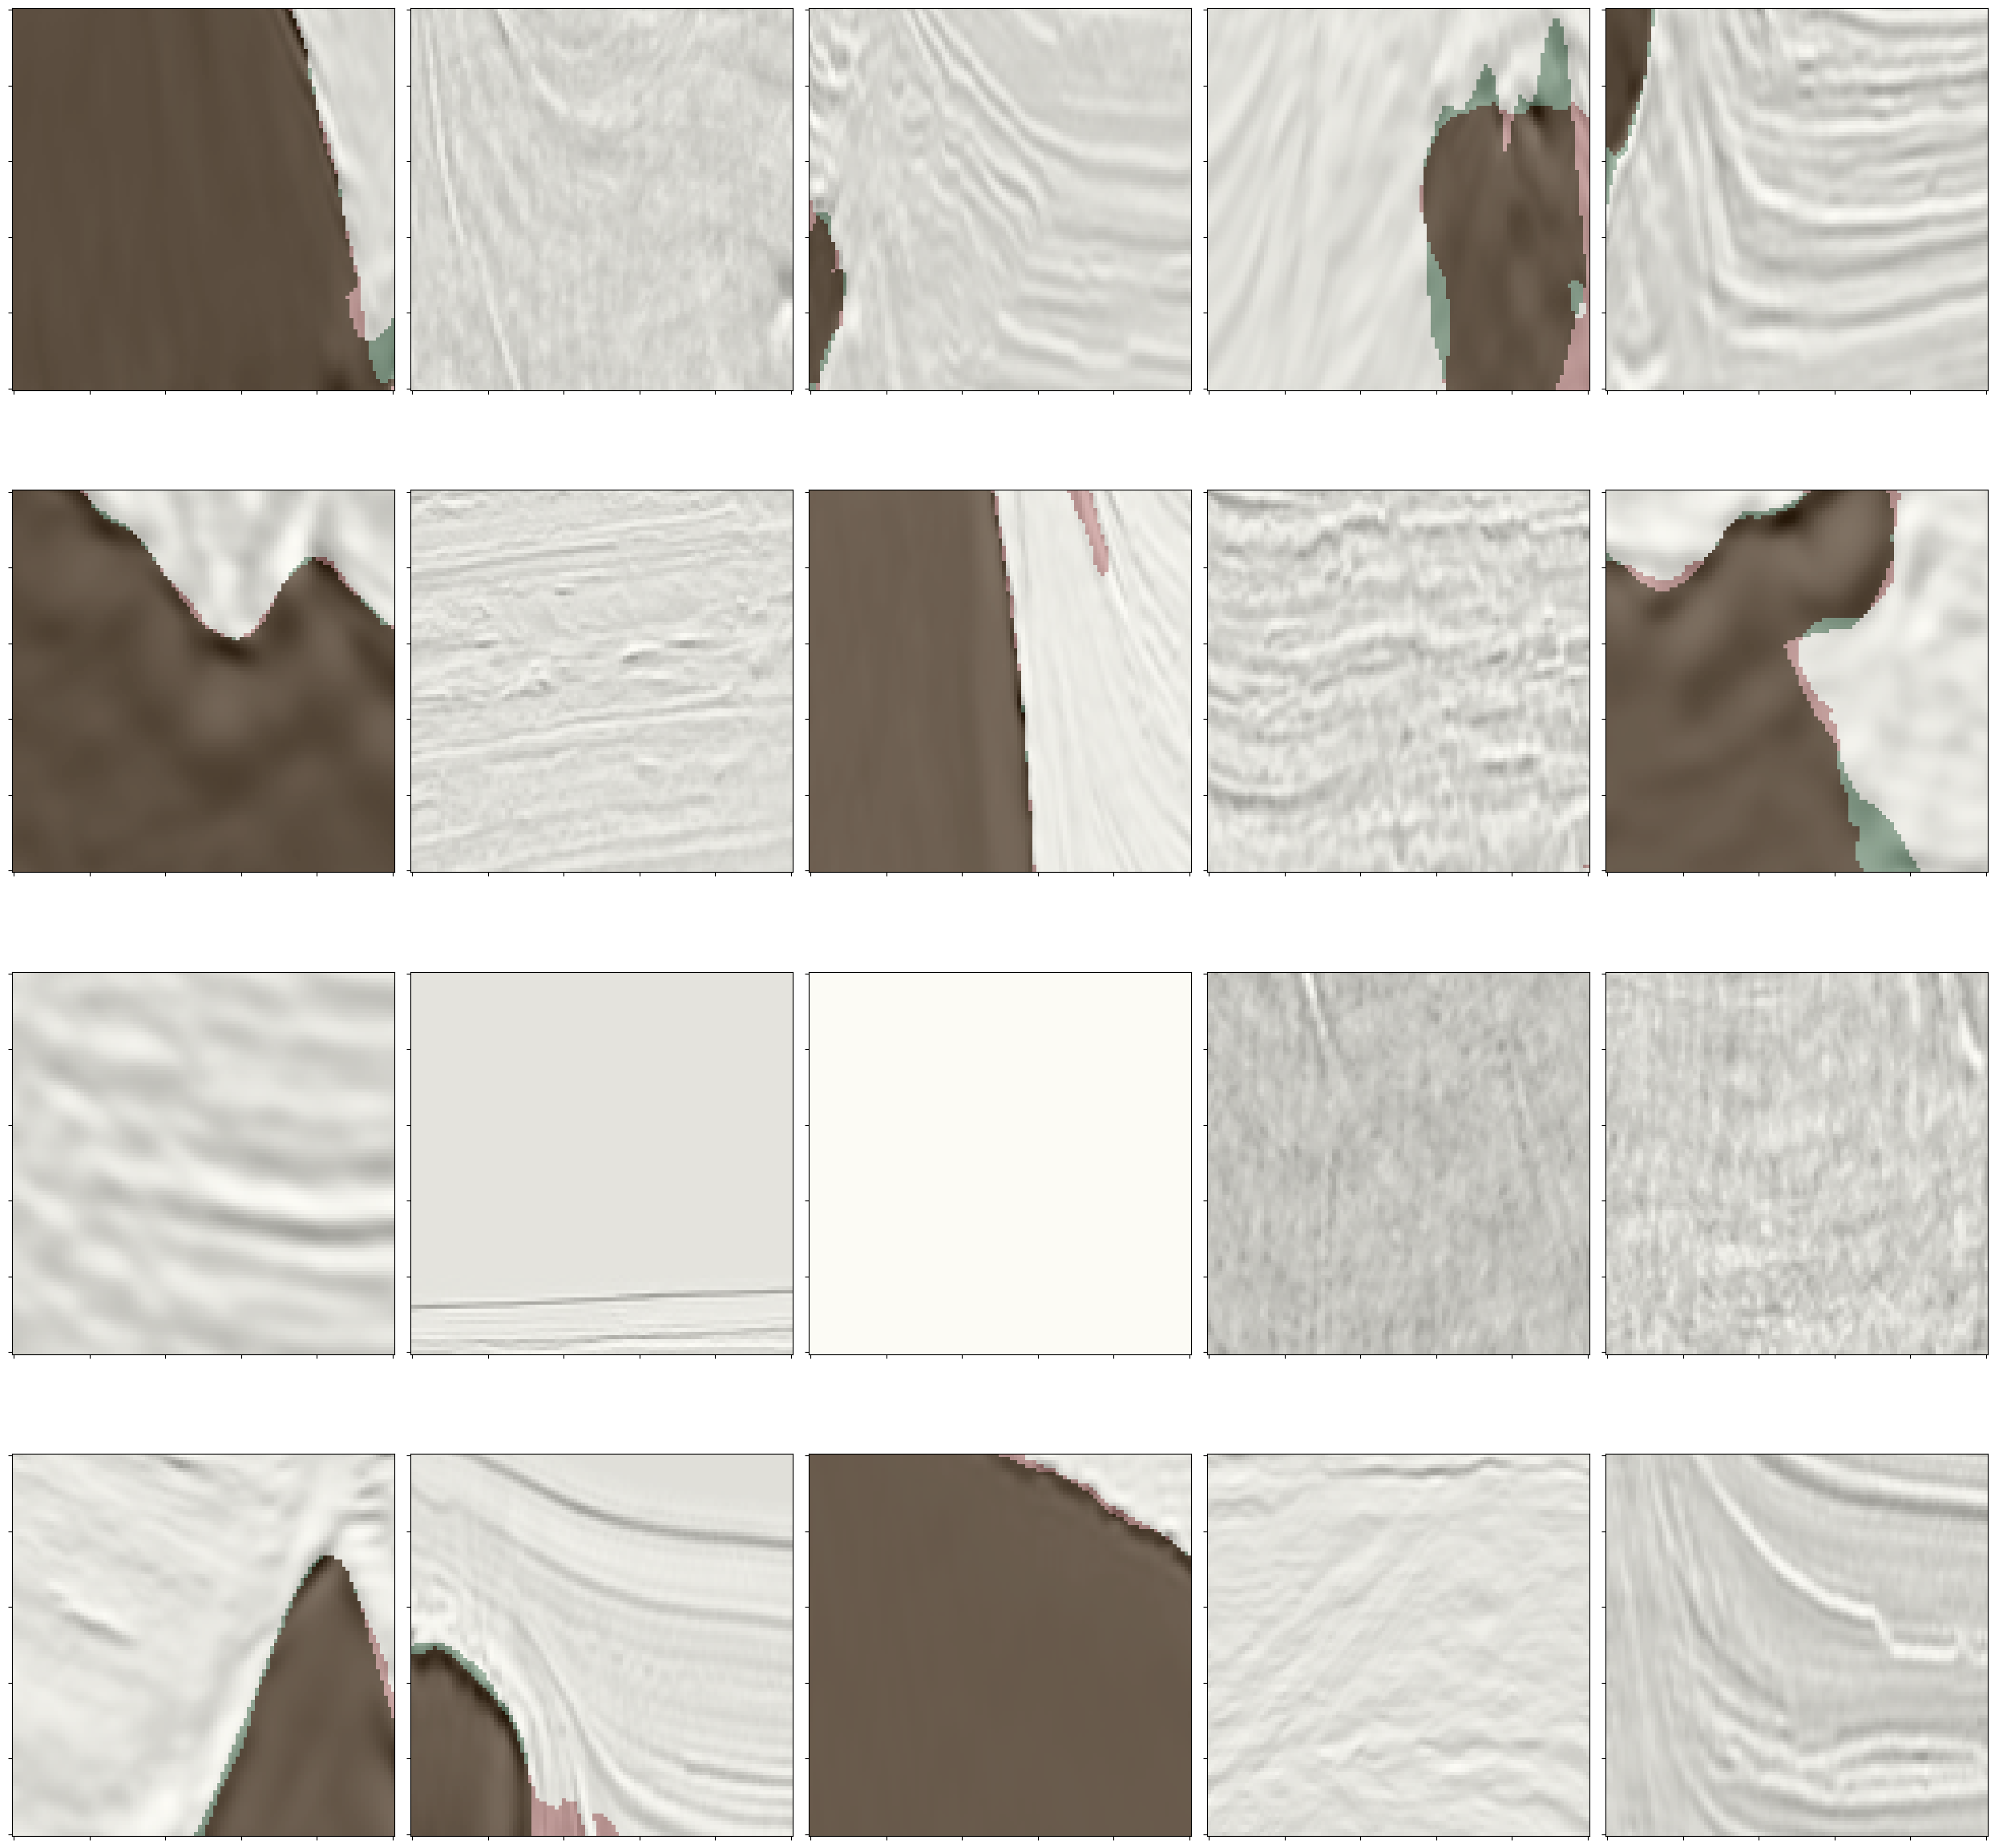

In [ ]:
# Step 22: Visualize Predictions

# Define the number of images to display
num_images = 20

# Define the number of images per row and column
num_rows = 4
num_cols = 5

# Define the size of the overall figure
fig_width = 25
fig_height = 25

# Calculate the size of each subplot based on the number of rows and columns
sub_width = fig_width / num_cols
sub_height = fig_height / num_rows

# Create a figure and subplots with the specified size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Loop through each image
for i in range(num_images):
    # Extract the image, ground truth mask, prediction, and IoU
    image, mask, pred, iou = images[i], masks[i], preds[i], ious[i]

    # Get the corresponding axis for the subplot
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Plot the original image
    ax.imshow(image.squeeze(), cmap="Greys")

    # Overlay the ground truth mask with green color
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")

    # Overlay the model prediction with red color and reduced opacity
    ax.imshow(pred.squeeze(), alpha=0.3, cmap="OrRd")

    # Round the IoU score to two decimal places
    iou_rounded = round(iou, 2)

    # Set the title with the rounded IoU score
    # ax.set_title(f"IoU: {iou_rounded}", loc='left', fontsize=12)

    # Remove tick labels for better visualization
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add legend for color representation
legend_elements = [plt.Line2D([0], [0], color='gray', lw=4, label='Original Image'),
                   plt.Line2D([0], [0], color='green', lw=4, label='Ground Truth Mask'),
                   plt.Line2D([0], [0], color='red', lw=4, label='Model Prediction')]

# Add legend to the figure
# plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3, fontsize=12)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()